# Implementing and Evaluating Linear Regression

# Introduction

In this phase of our analysis, our aim is to deploy and assess a Linear Regression model on our prepared dataset. The principal objective is to generate reliable predictions of sales revenue, specific to each product and, on a broader scale, each product category.
Our first step involves separating our data into dependent and independent variables. In this scenario, our focus, or the 'target' variable, is 'sales_revenue'.
Subsequently, we partition our dataset into distinctive training, testing, and validation subsets. Upon establishing a baseline model, we evaluate its performance employing various metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). We will also gauge the model's coefficient of determination (R-squared) on both training and validation sets.
Further evaluation includes analyzing the model's residual patterns with the predicted values to check for homoscedasticity. We also scrutinize the residual Quantile-Quantile (QQ) plot for more insights into the model's predictive performance.
Finally, we draw conclusions regarding the effectiveness of this model in accurately predicting our target variable, i.e., sales revenue.

In [1]:
# import the relevant libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

We begin by loading our cleaned dataset, where irrelevant features have been removed. 

In [2]:
# Load the data 
df = pd.read_csv('Olist_Final.csv')
df.head()

,product_id,item_price,freight_value,payment_sequential,payment_type,payment_installments,order_purchase_timestamp,review_score,postal_code,state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,sales_revenue
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,1,1,2,2017-09-13 08:59:00,5,28013,18,cool_stuff,650.0,28.0,9.0,14.0,58.9
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,1,0,1,2017-06-28 11:52:00,5,75800,8,cool_stuff,650.0,28.0,9.0,14.0,55.9
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,1,1,2,2018-05-18 10:25:00,4,30720,10,cool_stuff,650.0,28.0,9.0,14.0,64.9
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,1,1,3,2017-08-01 18:38:00,5,83070,17,cool_stuff,650.0,28.0,9.0,14.0,58.9
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,1,1,4,2017-08-10 21:48:00,5,36400,10,cool_stuff,650.0,28.0,9.0,14.0,58.9


## Data Scaling and Regression Analysis

We then assign the data to variables X and Y. As we want 'product_id' to be one of our features to help predict on a product-by-product basis, we create a copy of it from X before dropping it from the variable.Next, we split the data into training and testing sets. The training data is further split into separate training and validation sets.

In [3]:
# Assign the X features.
X = df.drop(['sales_revenue', 'order_purchase_timestamp','product_category_name'], axis=1)

# Assign 'sales_revenue' column as the target variable 'y'.
y = df['sales_revenue']

# Keep a copy of the Product ID for the test set before dropping from X
X_Product_IDs = X['product_id'].copy()

# Drop the Product ID from X
X = X.drop('product_id', axis=1)

# Split the data into train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split train_val set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In the subsequent step, we scale the data and combine preprocessing tasks into a pipeline. This pipeline is then used to train a linear regression model on the training set. Following this, we make predictions on the test set using the fitted model and generate a dataframe of predictions indexed by 'product_id'.

In [4]:
# Define preprocessing for numerical columns (scale them)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to train a linear regression model on the training set
pipeline.fit(X_train, y_train)

# Make predictions on the test set using the fitted model
y_pred_test = pipeline.predict(X_test)

# Create a DataFrame for the predictions, indexed by Product ID
df_predictions = pd.DataFrame({
    'product_id': X_Product_IDs.loc[X_test.index],
    'Actual': y_test,
    'Predicted': y_pred_test
})

print(df_predictions)

                             product_id   Actual   Predicted
79496  cf3aebf1fe742d73907fed51ead1945c   119.90  123.489185
693    1fe8e6e01596885617fa1c90d29c2f81    81.56   99.475358
18245  db0e75ba1fc6537d68f2676f3b67d07f   249.99  269.808143
30359  41c24b8ce92d1a2cac62db5edfd088b2    99.90  116.281214
63301  e0cf79767c5b016251fe139915c59a26    29.90   32.152265
...                                 ...      ...         ...
39731  e9def91e99c8ecb7c5cef5e31506a056    69.99   72.502745
92284  06601c3059e35a3bf65e72f2fd2ac626   109.90  117.287292
23099  26e253f334cf93847fcbf6e9faf51eb4   169.00  192.667937
29587  ee3d532c8a438679776d222e997606b3  1200.00  131.106895
28118  542b3d80712d51eefe3a3cd1c5f4e8fe    42.90   51.030007

[23073 rows x 3 columns]


Now, we turn our attention to model evaluation. We consider the R-squared values for training, validation, and testing. As we observe, the model exhibits an R-squared value of approximately 85% for the training set, 66% for the validation set, and 82% for the test set. These metrics suggest our model has a reasonably good predictive capability.

In [5]:
# Make predictions on the train, validation, and test sets
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Calculate R-squared scores
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

print('Train R2 score: ', r2_train)
print('Validation R2 score: ', r2_val)
print('Test R2 score: ', r2_test)

Train R2 score:  0.856236659431715
Validation R2 score:  0.6670402594514427
Test R2 score:  0.8205693417304952


Below, we evaluate the coefficients of different features. As we can see, 'item_price' has the highest coefficient value of 186.95, whereas 'review_score' has the lowest, at -6.95.

In [6]:
# Create a dataframe for the coefficients
coef_df = pd.DataFrame(pipeline.named_steps['regressor'].coef_, X.columns, columns=['Coefficient'])

# Append the intercept
coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))

# Display the dataframe
print(coef_df)

                      Coefficient
item_price             186.958715
freight_value           -1.820749
payment_sequential       1.771930
payment_type            -3.995002
payment_installments     5.665397
review_score            -6.954469
postal_code              0.472981
state                    0.169272
product_weight_g         3.295150
product_length_cm        1.343022
product_height_cm        2.442709
product_width_cm        -1.386328
Intercept              135.700846


C:\Users\Work&Study\AppData\Local\Temp\ipykernel_18952\1603916518.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))


Lastly, we evaluate the model's performance using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). These metrics will provide additional insight into our model's predictive accuracy.

In [7]:
# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Calculate MPE
mpe = np.mean((y_test - y_pred_test) / y_test) * 100

# Calculate PRMSE
prmse = (np.sqrt(np.mean((y_test - y_pred_test) ** 2)) / np.mean(y_test)) * 100

# Print the metrics
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Mean Percentage Error (MPE): {:.2f}%".format(mpe))
print("Percentage Root Mean Squared Error (PRMSE): {:.2f}%".format(prmse))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Mean Absolute Percentage Error (MAPE): 24.05%
Mean Percentage Error (MPE): -12.55%
Percentage Root Mean Squared Error (PRMSE): 65.79%
Mean Absolute Error: 27.09516029120471
Mean Squared Error: 8068.8150904377635
Root Mean Squared Error: 89.82658342850274


The above evaluated, showed some areas for improvement. With a Mean Absolute Percentage Error (MAPE) of 24.05% and a Mean Percentage Error (MPE) of -12.55%, the model is on average approximately 24% off in its predictions and tends to underestimate the actual values. Additionally, the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) values of 8068.815 and 89.826 respectively suggest a high level of error in the model's predictions, pointing towards a need for further optimization and refinement of the model.

In the following stage, we will visualize the residuals against the predicted values (homoscedasticity) to assess the distribution of our model's residuals. This step provides us with a more visual understanding of our model's performance.

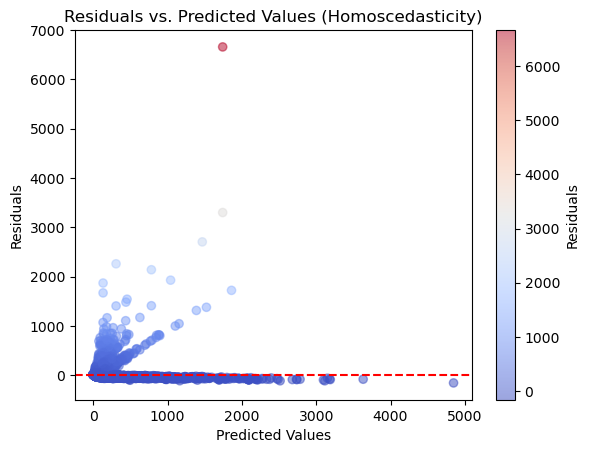

In [8]:
residuals = y_test - y_pred_test

# Plotting the residuals against the predicted values with color-coded data points
import matplotlib.pyplot as plt
plt.scatter(y_pred_test, residuals, alpha=0.5, c=residuals, cmap='coolwarm')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Homoscedasticity)')
plt.colorbar(label='Residuals')  # Add a colorbar indicating the range of residuals
plt.show()

The above scatter plot indicates mixed results in our model's predictions. Some parts of the data appear to be predicted well, while others do not align as closely with the true values.

Next, we will create a Quantile-Quantile (QQ) plot for the residuals. This plot is a graphical tool to help us understand if our residuals follow a normal distribution, an assumption underlying many statistical models.

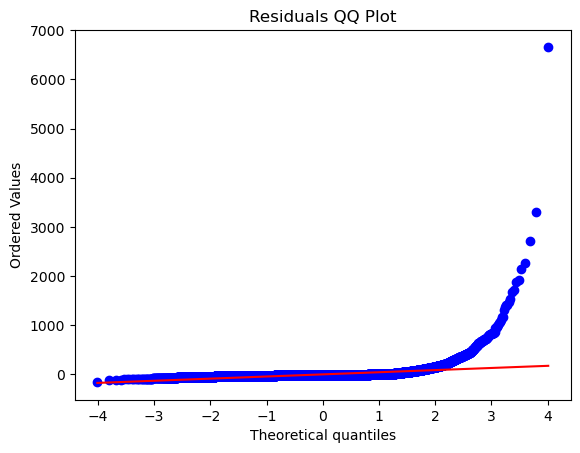

In [9]:
stats.probplot(residuals, plot=plt)
plt.title('Residuals QQ Plot')
plt.show()

From the QQ plot, we can discern that our model's residuals are not perfectly normally distributed, indicating that our model's predictions may not be optimal in certain areas.

# Conclusion

After a comprehensive analysis and evaluation of our Linear Regression model, it's clear that while it exhibits strengths in some areas, it falls short in others. The model demonstrated decent predictive accuracy for certain sections of our data, but struggled to maintain this accuracy across the entire dataset.

To conclude, our Linear Regression model, despite its partial successes, did not fully meet our predictive needs for this specific dataset. This highlights the need for further exploration of other modeling techniques that could offer improved predictive accuracy for our sales revenue data. This study's findings will inform our future efforts as we continue our search for the most appropriate and efficient predictive model.